# `DSML Workshop 05` - Hands on Data Science with real-world geotagged data

During this workshop we dive into an excerpt of Car2Go data from the city of Stuttgart (STR). We will work hands-on with the dataset, which you can find on ILIAS. At the end of this session you should:

- understand the dataset and be able to query, analyze and plot it
- enrich the dataset with further features
- do basic geographical plots in folium
- understand the business case behind Virtual Power Plants and how they interact with the ancillary services markets

## `Data Preparation and Exploration`

### 1.1 Read in data and perform basic transformations

To keep size manageable we have uploaded a 2-week data snippet of Car2Go movement data from the city of Stuttgart (STR). We use data from November, 2017. In the interest of time we have done a lot of the pre-processing for you. Simply execute the code below to read in the data in the desired format.

**Note**: I received the feedback that some of you are having problems with creating an environment for this notebook. Originally, you needed this environment for pyrosm, the library required to obtain location data. Given the issues with pyrosm, we decided to provide you with the location information for Stuttgart as a csv file, which you can find on ILIAS. Consequently, you do not need to use pyrosm and this updated version of the notebook should work with the environment that you use for all DSML workshops. Additionally, we will provide you with the location data of your team assignment cities, which has been added to the data folder (see link in team assignment document).

In [1]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_palette("GnBu_d")

# also import these "new" libraries 
# Note: you may have to download an add them to your environment (using e.g. 'conda install -c conda-forge folium')
import folium
from folium import plugins
from folium.plugins import HeatMap
import geopandas as gpd
from datetime import datetime #for working with times objects
from datetime import timedelta #for working with times objects
import math
import random

In [2]:
STR_Nov = pd.read_csv("Car2Go_STR_Nov.csv", encoding = "ISO-8859-1") # read in data
STR_Nov.sort_values(["car ID","timestamp"], inplace=True) # sort values by car ID and timestamp
STR_Nov.set_index(pd.DatetimeIndex(STR_Nov["timestamp"]),inplace=True) # make timestamp index and transform to datetime
STR_Nov.drop("timestamp", axis=1, inplace=True) # drop datetime column

In [3]:
# check out the data
STR_Nov.head(10)

,car ID,long,lat,address,tank/charge level,charging
timestamp,,,,,,
2017-11-01 00:10:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0
2017-11-01 00:15:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0
2017-11-01 00:20:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0
2017-11-01 00:25:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0
2017-11-01 00:30:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0
2017-11-01 00:35:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0
2017-11-01 01:25:02,WDD2428901J014865,9.16111,48.77170,"HasenbergstraÃe 32, 70176 Stuttgart",43,0
2017-11-01 01:30:01,WDD2428901J014865,9.16111,48.77170,"HasenbergstraÃe 32, 70176 Stuttgart",43,0
2017-11-01 01:35:01,WDD2428901J014865,9.16111,48.77170,"HasenbergstraÃe 32, 70176 Stuttgart",43,0


In [4]:
# note the type of the index
type(STR_Nov.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [5]:
# familiarize yourself with the data
print(STR_Nov.info())
print(STR_Nov.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1393195 entries, 2017-11-01 00:10:01 to 2017-11-14 21:45:01
Data columns (total 6 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   car ID             1393195 non-null  object 
 1   long               1393195 non-null  float64
 2   lat                1393195 non-null  float64
 3   address            1393195 non-null  object 
 4   tank/charge level  1393195 non-null  int64  
 5   charging           1393195 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 74.4+ MB
None
               long           lat  tank/charge level      charging
count  1.393195e+06  1.393195e+06       1.393195e+06  1.393195e+06
mean   9.170557e+00  4.876111e+01       7.241289e+01  3.100356e-02
std    7.507871e-02  3.899275e-02       2.098999e+01  1.733273e-01
min    8.946480e+00  4.865150e+01       1.300000e+01  0.000000e+00
25%    9.128420e+00  4.873205e+01       5.700000e+01

### 1.2 Data prep and engineering: datetime

The dataset contains temporal data. Therefore, we can generate interesting features from the datetime information.

In [6]:
# Let's map time of day and day of week to our DF
def get_date(ts):
    return ts.date()

def get_weekday(ts):
    return ts.weekday()

def get_hour(ts):
    return ts.hour

For this we will be using `lambda` in combination with `.apply()` - a very powerful combination for row-wise operations which allows you to apply any self-defined function to an element in a df.

In [7]:
STR_Nov.reset_index(inplace=True) # first, we reset the index so that timestamp becomes a column of our dataframe
STR_Nov["Date"] = STR_Nov["timestamp"].apply(lambda x: get_date(x))
STR_Nov["Weekday"]=STR_Nov["timestamp"].apply(lambda x: get_weekday(x))
STR_Nov["Hour"]=STR_Nov["timestamp"].apply(lambda x: get_hour(x))

STR_Nov.head()

,timestamp,car ID,long,lat,address,tank/charge level,charging,Date,Weekday,Hour
0,2017-11-01 00:10:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0
1,2017-11-01 00:15:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0
2,2017-11-01 00:20:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0
3,2017-11-01 00:25:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0
4,2017-11-01 00:30:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0


Most of the time, there is a faster alternative. In this case, you can also use the .dt accessor for datetime columns:

In [8]:
STR_Nov['timestamp'].dt.date

0          2017-11-01
1          2017-11-01
2          2017-11-01
3          2017-11-01
4          2017-11-01
              ...    
1393190    2017-11-14
1393191    2017-11-14
1393192    2017-11-14
1393193    2017-11-14
1393194    2017-11-14
Name: timestamp, Length: 1393195, dtype: object

In [9]:
STR_Nov['Date']

0          2017-11-01
1          2017-11-01
2          2017-11-01
3          2017-11-01
4          2017-11-01
              ...    
1393190    2017-11-14
1393191    2017-11-14
1393192    2017-11-14
1393193    2017-11-14
1393194    2017-11-14
Name: Date, Length: 1393195, dtype: object

### 1.3 Data prep and engineering: merge further data

You might have interesting information from other sources that you want to include in your analysis. First, let's pretend that Car2Go provides us with a second dataset that contains information on the type of cars in their fleet.

In [10]:
# first, we generate our hypothetical car model data
brands = ["Fiat", "BMW", "Volkswagen", "Ford", "Volvo", "Tesla", "Porsche"]
seats = [2,3,4,5]
color = ["grey", "black", "blue", "red", "green"]

car_models = pd.DataFrame({"car_id": STR_Nov["car ID"].unique()})
car_models["brand"] = np.random.choice(brands, len(car_models))
car_models["seats"] = np.random.choice(seats, len(car_models))
car_models["color"] = np.random.choice(color, len(car_models))

car_models.head()

,car_id,brand,seats,color
0,WDD2428901J014865,Tesla,2,grey
1,WDD2428901J014882,BMW,4,grey
2,WDD2428901J014884,Fiat,3,red
3,WDD2428901J014886,Ford,3,grey
4,WDD2428901J014888,Tesla,3,red


In [11]:
# next, we merge the car model data with our main dataframe
STR_Nov_cars = STR_Nov.merge(car_models, how = "left", left_on = "car ID", right_on = "car_id")

STR_Nov_cars.head()

,timestamp,car ID,long,lat,address,tank/charge level,charging,Date,Weekday,Hour,car_id,brand,seats,color
0,2017-11-01 00:10:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0,WDD2428901J014865,Tesla,2,grey
1,2017-11-01 00:15:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0,WDD2428901J014865,Tesla,2,grey
2,2017-11-01 00:20:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0,WDD2428901J014865,Tesla,2,grey
3,2017-11-01 00:25:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0,WDD2428901J014865,Tesla,2,grey
4,2017-11-01 00:30:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0,WDD2428901J014865,Tesla,2,grey


Second, let's pretend that we have information on the urban traffic congestion in Stuttgart. Specifically, we have information on the average additional time spent during a 10km car trip in the inner city for every hour

In [12]:
# first, we generate our hypothetical congestion data
congestion = pd.DataFrame({'timestamp': pd.date_range('2017-11-01', '2017-11-15', periods=85, inclusive='left')})
congestion["congestion"] = np.random.randint(0,20, len(congestion))

In [13]:
congestion.head()

,timestamp,congestion
0,2017-11-01 00:00:00,12
1,2017-11-01 04:00:00,8
2,2017-11-01 08:00:00,16
3,2017-11-01 12:00:00,8
4,2017-11-01 16:00:00,15


In [14]:
# next, we merge the congestion data with our main dataframe
# note that in contrast to the car model data, we do not have any column that exactly matches in both dataframes
# for merges on datetime, pd.merge_asof comes to the rescue

# for this to work, both dataframes must be sorted by datetime
STR_Nov.sort_values("timestamp", inplace=True)

STR_Nov_congestion = pd.merge_asof(STR_Nov, congestion, on = "timestamp", direction = "nearest")

In [15]:
# let's return to our original sorting by car ID and timestamp and inspect the data
STR_Nov_congestion.sort_values(["car ID","timestamp"], inplace=True)

STR_Nov_congestion.head(10)

,timestamp,car ID,long,lat,address,tank/charge level,charging,Date,Weekday,Hour,congestion
729,2017-11-01 00:10:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0,12
1295,2017-11-01 00:15:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0,12
1464,2017-11-01 00:20:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0,12
1989,2017-11-01 00:25:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0,12
2206,2017-11-01 00:30:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0,12
2356,2017-11-01 00:35:01,WDD2428901J014865,9.25371,48.76507,"Heiligenwiesen 31, 70327 Stuttgart",55,0,2017-11-01,2,0,12
6081,2017-11-01 01:25:02,WDD2428901J014865,9.16111,48.77170,"HasenbergstraÃe 32, 70176 Stuttgart",43,0,2017-11-01,2,1,12
6319,2017-11-01 01:30:01,WDD2428901J014865,9.16111,48.77170,"HasenbergstraÃe 32, 70176 Stuttgart",43,0,2017-11-01,2,1,12
6746,2017-11-01 01:35:01,WDD2428901J014865,9.16111,48.77170,"HasenbergstraÃe 32, 70176 Stuttgart",43,0,2017-11-01,2,1,12
7060,2017-11-01 01:40:01,WDD2428901J014865,9.16111,48.77170,"HasenbergstraÃe 32, 70176 Stuttgart",43,0,2017-11-01,2,1,12


### Task <br>

- In the above merge operation, set the direction to "nearest", "backward" and "forward"
- What changes? Which option makes most sense in the given context?

### 1.4 Data prep and engineering: locations

The dataset contains geospatial data. Therefore, we can generate interesting features from the location information. To do that, we first convert our dataframe to a gepandas dataframe that allows for geographical operations on so called geometry columns. 

In [40]:
# let's load the Stuttgart locations data and convert it to a geopandas dataframe
# note: x and y replace lon and lat here (long, lat) = (x, y)
stuttgart_loc = pd.read_csv("Stuttgart_POIS.csv")
shopping_pois = gpd.GeoDataFrame(stuttgart_loc, geometry=gpd.points_from_xy(stuttgart_loc['lon'], stuttgart_loc['lat']))

In [41]:
shopping_pois.head()

,Unnamed: 0,tags,version,lat,lon,timestamp,id,changeset,addr:city,addr:country,...,shop,tobacco,trade,watches,wholesale,brand,geometry,osm_type,agrarian,kiosk
0,0,"{""brand:wikidata"":""Q16968817"",""brand:wikipedia...",0,48.530796,9.079883,0,31605827,0.0,Tübingen,DE,...,supermarket,NaN,NaN,NaN,NaN,REWE,POINT (9.07988 48.53080),node,NaN,NaN
1,1,"{""addr:suburb"":""Lustnau"",""contact:phone"":""+49 ...",0,48.530790,9.079736,0,31605828,0.0,Tübingen,DE,...,bakery,NaN,NaN,NaN,NaN,NaN,POINT (9.07974 48.53079),node,NaN,NaN
2,2,"{""fax"":""+49 7071 84629"",""source"":""knowledge"",""...",0,48.530870,9.079653,0,31605830,0.0,Tübingen,DE,...,butcher,NaN,NaN,NaN,NaN,NaN,POINT (9.07965 48.53087),node,NaN,NaN
3,3,"{""amenity"":""fuel"",""compressed_air"":""yes"",""fuel...",0,48.719585,9.207897,0,32589162,0.0,Stuttgart,DE,...,kiosk,NaN,NaN,NaN,NaN,Agip,POINT (9.20790 48.71959),node,NaN,NaN
4,4,"{""amenity"":""fuel"",""fuel:diesel"":""yes"",""fuel:oc...",0,48.514980,9.225251,0,33657618,0.0,NaN,NaN,...,kiosk,NaN,NaN,NaN,NaN,NaN,POINT (9.22525 48.51498),node,NaN,NaN


In [27]:
# next, we convert our Car2Go dataframe to a geopandas dataframe
# note: x and y replace long and lat here (long, lat) = (x, y)
str_nov_geo = gpd.GeoDataFrame(STR_Nov, geometry=gpd.points_from_xy(STR_Nov['long'], STR_Nov['lat']))

In [31]:
str_nov_geo.head()

,timestamp,car ID,long,lat,address,tank/charge level,charging,Date,Weekday,Hour,geometry
1355588,2017-11-01 00:00:01,WME4513901K820402,9.16004,48.78306,"KornbergstraÃe 32, 70176 Stuttgart",81,0,2017-11-01,2,0,POINT (9.16004 48.78306)
767009,2017-11-01 00:00:01,WME4513901K682887,9.15871,48.81197,"Wilhelm-Geiger-Platz 10, 70469 Stuttgart",95,1,2017-11-01,2,0,POINT (9.15871 48.81197)
504851,2017-11-01 00:00:01,WME4513901K664097,9.01996,48.70894,"Hugo-Distler-StraÃe 6, 71065 Sindelfingen",84,0,2017-11-01,2,0,POINT (9.01996 48.70894)
540369,2017-11-01 00:00:01,WME4513901K666870,9.29360,48.75934,"Sulzgrieser StraÃe 105, 73733 Esslingen",100,1,2017-11-01,2,0,POINT (9.29360 48.75934)
1084629,2017-11-01 00:00:01,WME4513901K728465,9.15659,48.84287,"Marco-Polo-Weg 8, 70439 Stuttgart",100,0,2017-11-01,2,0,POINT (9.15659 48.84287)


Notice the difference between the dataframes before and after: there is a new column called geometry. This is a column that enables the geopandas operations on this dataframe.

<Axes: >

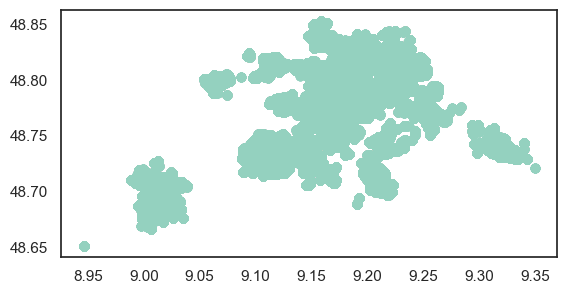

In [32]:
str_nov_geo.plot()

Here you can see a nice feature - plotting the geometries on a map. It is hard to see anything, so later we are going to add a layer with a map.

Up for the next step. In the shopping POIs we fetched from Open Street Map, you can see a collection of shops with a LOT of attributes. Don't be scared, there are some that are useful to us. A later column is called 'shop' and it contains different shop types

In [33]:
shopping_pois.head()

,Unnamed: 0,tags,version,lat,lon,timestamp,id,changeset,addr:city,addr:country,...,shop,tobacco,trade,watches,wholesale,brand,geometry,osm_type,agrarian,kiosk
0,0,"{""brand:wikidata"":""Q16968817"",""brand:wikipedia...",0,48.530796,9.079883,0,31605827,0.0,Tübingen,DE,...,supermarket,NaN,NaN,NaN,NaN,REWE,POINT (9.07988 48.53080),node,NaN,NaN
1,1,"{""addr:suburb"":""Lustnau"",""contact:phone"":""+49 ...",0,48.530790,9.079736,0,31605828,0.0,Tübingen,DE,...,bakery,NaN,NaN,NaN,NaN,NaN,POINT (9.07974 48.53079),node,NaN,NaN
2,2,"{""fax"":""+49 7071 84629"",""source"":""knowledge"",""...",0,48.530870,9.079653,0,31605830,0.0,Tübingen,DE,...,butcher,NaN,NaN,NaN,NaN,NaN,POINT (9.07965 48.53087),node,NaN,NaN
3,3,"{""amenity"":""fuel"",""compressed_air"":""yes"",""fuel...",0,48.719585,9.207897,0,32589162,0.0,Stuttgart,DE,...,kiosk,NaN,NaN,NaN,NaN,Agip,POINT (9.20790 48.71959),node,NaN,NaN
4,4,"{""amenity"":""fuel"",""fuel:diesel"":""yes"",""fuel:oc...",0,48.514980,9.225251,0,33657618,0.0,NaN,NaN,...,kiosk,NaN,NaN,NaN,NaN,NaN,POINT (9.22525 48.51498),node,NaN,NaN


In [42]:
# let's filter our location data 
shopping_pois = shopping_pois[shopping_pois['brand'] == 'Lidl'] # we now only want Lidl for later analysis
shopping_pois.dropna(axis='columns', thresh=25, inplace=True) # lets also drop NA columns, as they are not useful for us. The thresh parameter can be used to control how many entries have to be there to keep the column
shopping_pois = shopping_pois[shopping_pois['addr:city'] == 'Stuttgart'] # finally, we are only interested in locations in the city of Stuttgart

shopping_pois.head()

,Unnamed: 0,tags,version,lat,lon,timestamp,id,changeset,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,name,opening_hours,operator,shop,brand,geometry,osm_type
21,21,"{""brand:wikidata"":""Q151954"",""brand:wikipedia"":...",0,48.811302,9.165339,0,59656294,0.0,Stuttgart,DE,32,70469.0,Stuttgarter Straße,Lidl,Mo-Fr 08:00-21:00; Sa 08:00-21:00; PH off,Lidl Vertriebs-GmbH & Co. KG,supermarket,Lidl,POINT (9.16534 48.81130),node
141,141,"{""brand:wikidata"":""Q151954"",""brand:wikipedia"":...",0,48.779740,9.167623,0,264885086,0.0,Stuttgart,DE,12,70174.0,Breitscheidstraße,Lidl,Mo-Fr 08:00-21:00; Sa 08:00-21:00; PH off,Lidl Vertriebs-GmbH & Co. KG,supermarket,Lidl,POINT (9.16762 48.77974),node
146,146,"{""addr:suburb"":""Botnang"",""contact:email"":""kont...",0,48.778800,9.125645,0,266175760,0.0,Stuttgart,DE,2,70195.0,Griegstraße,Lidl,Mo-Fr 07:00-21:00; Sa 07:00-21:00; PH off,Lidl Vertriebs-GmbH & Co. KG,supermarket,Lidl,POINT (9.12565 48.77880),node
167,167,"{""brand:wikidata"":""Q151954"",""brand:wikipedia"":...",0,48.775486,9.155695,0,268510495,0.0,Stuttgart,DE,91,70193.0,Schwabstraße,Lidl,Mo-Sa 07:00-22:00; PH off,Lidl Vertriebs-GmbH & Co. KG,supermarket,Lidl,POINT (9.15569 48.77549),node
427,427,"{""addr:suburb"":""Mitte"",""brand:wikidata"":""Q1519...",0,48.773495,9.173240,0,311737339,0.0,Stuttgart,DE,12,70178.0,Marienstraße,Lidl,Mo-Fr 08:00-22:00; Sa 08:00-22:00; PH off,Lidl Vertriebs-GmbH & Co. KG,supermarket,Lidl,POINT (9.17324 48.77349),node


Now we have two geodataframes, both with geographical information. However, the coordinates might be in differing formats. Coordinate reference systems (short CRS) are used to tell you: we have defined the coordinates to follow this particular model. We are using one called WGS84, that can be found using a code from a database. That database is called EPSG. In it, WGS84 has the code 4326.

In [45]:
# there is currently no coordinate reference system set for either of the two dataframes
print(str_nov_geo.crs)
print(shopping_pois.crs)

None
None


In [46]:
# to make the two geodataframes speak to each other, we need to set the crs for both to be equal
str_nov_geo = str_nov_geo.set_crs(epsg=4326)
shopping_pois = shopping_pois.set_crs(epsg=4326)

In [48]:
# now, the crs in both dataframes is defined
str_nov_geo.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [49]:
shopping_pois.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [50]:
# check out the first LIDL supermarket in our list
shopping_pois.iloc[0]

Unnamed: 0                                                         21
tags                {"brand:wikidata":"Q151954","brand:wikipedia":...
version                                                             0
lat                                                         48.811302
lon                                                          9.165339
timestamp                                                           0
id                                                           59656294
changeset                                                         0.0
addr:city                                                   Stuttgart
addr:country                                                       DE
addr:housenumber                                                   32
addr:postcode                                                 70469.0
addr:street                                        Stuttgarter Straße
name                                                             Lidl
opening_hours       

In [51]:
# we could calculate the distance for each Car2Go location to this supermarket easily using the .distance function
str_nov_geo.distance(shopping_pois.iloc[0].geometry)

/var/folders/w2/qvkw67fs4gz183wq08fkfbx80000gp/T/ipykernel_4291/2304221872.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  str_nov_geo.distance(shopping_pois.iloc[0].geometry)


1355588    0.028735
767009     0.006663
504851     0.177801
540369     0.138387
1084629    0.032758
             ...   
1257593    0.049720
69338      0.082942
1018211    0.052910
760835     0.067751
310241     0.036889
Length: 1393195, dtype: float64

Distance calculation is actually quite simple for a single point, as you can see above. However the CRS strikes again... The warning above tells you that the distance results are likely to be complete rubbish. That is because the distance is calculated between degrees and not points in meters. To get good results, we need to convert the coordinates to a projected CRS, which is given in meters.

A nice website for looking up CRS is epsg.io. There we can search for a variety of CRS. On such projected system that gives coordinates in meters is Europe UTM. UTM is a projection that is split into 'slices'. Each slice is valid only for a part of the earth, which depends on the location you want to model. Use epsg.io to find the respective EPSG-code, which in our case is 25837. That we can simply enter into the conversion as you see below.

In [52]:
str_nov_geo = str_nov_geo.to_crs(epsg=25837)
str_nov_geo.head()

,timestamp,car ID,long,lat,address,tank/charge level,charging,Date,Weekday,Hour,geometry
1355588,2017-11-01 00:00:01,WME4513901K820402,9.16004,48.78306,"KornbergstraÃe 32, 70176 Stuttgart",81,0,2017-11-01,2,0,POINT (-1674638.247 5848117.906)
767009,2017-11-01 00:00:01,WME4513901K682887,9.15871,48.81197,"Wilhelm-Geiger-Platz 10, 70469 Stuttgart",95,1,2017-11-01,2,0,POINT (-1673384.661 5851282.209)
504851,2017-11-01 00:00:01,WME4513901K664097,9.01996,48.70894,"Hugo-Distler-StraÃe 6, 71065 Sindelfingen",84,0,2017-11-01,2,0,POINT (-1688111.645 5844439.999)
540369,2017-11-01 00:00:01,WME4513901K666870,9.29360,48.75934,"Sulzgrieser StraÃe 105, 73733 Esslingen",100,1,2017-11-01,2,0,POINT (-1666200.956 5841448.190)
1084629,2017-11-01 00:00:01,WME4513901K728465,9.15659,48.84287,"Marco-Polo-Weg 8, 70439 Stuttgart",100,0,2017-11-01,2,0,POINT (-1672093.973 5854685.356)


Now the geometries look strange, don't they? Actually, they are now more useful. The values you see there are the meters this point is away from (0,0). Now you can't really tell where on earth these locations are without knowing where (0,0) is, but you can calculate the distance using the euclidean formula! Lets put this to use.

In [53]:
shopping_pois = shopping_pois.to_crs(epsg=25837) # remember to change the CRS for our supermarket data as well
str_nov_geo['distance to Lidl Stuttgarter Str.'] = str_nov_geo.distance(shopping_pois.iloc[0].geometry) # calculate the distance to the first LIDL using .distance

In [54]:
str_nov_geo.sort_values(by=['distance to Lidl Stuttgarter Str.', 'timestamp'])

,timestamp,car ID,long,lat,address,tank/charge level,charging,Date,Weekday,Hour,geometry,distance to Lidl Stuttgarter Str.
36432,2017-11-11 10:45:01,WDD2428901J014914,9.16492,48.81139,"Stuttgarter Str. 36, 70469 Stuttgart",70,0,2017-11-11,5,10,POINT (-1672968.638 5851028.227),34.169991
36433,2017-11-11 10:50:01,WDD2428901J014914,9.16492,48.81139,"Stuttgarter Str. 36, 70469 Stuttgart",70,0,2017-11-11,5,10,POINT (-1672968.638 5851028.227),34.169991
36434,2017-11-11 10:55:01,WDD2428901J014914,9.16492,48.81139,"Stuttgarter Str. 36, 70469 Stuttgart",70,0,2017-11-11,5,10,POINT (-1672968.638 5851028.227),34.169991
36435,2017-11-11 11:00:01,WDD2428901J014914,9.16492,48.81139,"Stuttgarter Str. 36, 70469 Stuttgart",70,0,2017-11-11,5,11,POINT (-1672968.638 5851028.227),34.169991
36436,2017-11-11 11:05:01,WDD2428901J014914,9.16492,48.81139,"Stuttgarter Str. 36, 70469 Stuttgart",70,0,2017-11-11,5,11,POINT (-1672968.638 5851028.227),34.169991
...,...,...,...,...,...,...,...,...,...,...,...,...
139452,2017-11-14 23:50:01,WME4513901K649351,8.94648,48.65150,IBM | Ein- und Ausfahrt nur Ã¼ber Haupteingang,87,1,2017-11-14,1,23,POINT (-1696062.694 5840515.928),25388.285189
1132664,2017-11-14 23:50:01,WME4513901K728529,8.94648,48.65150,IBM | Ein- und Ausfahrt nur Ã¼ber Haupteingang,100,0,2017-11-14,1,23,POINT (-1696062.694 5840515.928),25388.285189
1280532,2017-11-14 23:55:01,WME4513901K820086,8.94648,48.65150,IBM | Ein- und Ausfahrt nur Ã¼ber Haupteingang,100,0,2017-11-14,1,23,POINT (-1696062.694 5840515.928),25388.285189
139453,2017-11-14 23:55:01,WME4513901K649351,8.94648,48.65150,IBM | Ein- und Ausfahrt nur Ã¼ber Haupteingang,88,1,2017-11-14,1,23,POINT (-1696062.694 5840515.928),25388.285189


Now we can see the distance to this Lidl for all cars, isn't that nice? For important locations in a city, like the central station, this can be very informative.

Given that we have lots of Lidls in Stuttgart, wouldn't it be a lot nicer to use more than just a single supermarket? Consider this idea: We create a circle around all supermarkets in Stuttgart, generate a geometry from this and finally simply check whether the location of a car is currently in one of these circles or not!

In [55]:
buffered_shops = shopping_pois.buffer(50) # create a circle of 50 meters around all points
all_shops = buffered_shops.unary_union # change format from series to single object

In [56]:
# check whether the Car2Go locations is within any of the circles around our Lidls
str_nov_geo['close_to_some_LIDL'] = str_nov_geo.within(all_shops)

In [62]:
# note the newly created binary variable
str_nov_geo.head()

,timestamp,car ID,long,lat,address,tank/charge level,charging,Date,Weekday,Hour,geometry,distance to Lidl Stuttgarter Str.,close_to_some_LIDL
1355588,2017-11-01 00:00:01,WME4513901K820402,9.16004,48.78306,"KornbergstraÃe 32, 70176 Stuttgart",81,0,2017-11-01,2,0,POINT (-1674638.247 5848117.906),3348.789336,False
767009,2017-11-01 00:00:01,WME4513901K682887,9.15871,48.81197,"Wilhelm-Geiger-Platz 10, 70469 Stuttgart",95,1,2017-11-01,2,0,POINT (-1673384.661 5851282.209),521.147501,False
504851,2017-11-01 00:00:01,WME4513901K664097,9.01996,48.70894,"Hugo-Distler-StraÃe 6, 71065 Sindelfingen",84,0,2017-11-01,2,0,POINT (-1688111.645 5844439.999),16528.834219,False
540369,2017-11-01 00:00:01,WME4513901K666870,9.29360,48.75934,"Sulzgrieser StraÃe 105, 73733 Esslingen",100,1,2017-11-01,2,0,POINT (-1666200.956 5841448.190),11696.206851,False
1084629,2017-11-01 00:00:01,WME4513901K728465,9.15659,48.84287,"Marco-Polo-Weg 8, 70439 Stuttgart",100,0,2017-11-01,2,0,POINT (-1672093.973 5854685.356),3776.191618,False


### Task: What do you observe? <br>

- Play around with the above dataframe trying using commands such as `df.head()`, `df.describe()` or `df.info()`
- What data is gathered, for what period, in what format and at which frequency?
- How do you explain the sudden jumps in the time-stamp?
- What can you infer about the status of each car?

In [ ]:
### YOUR CODE HERE









## `Descriptive Analyses`

Next, let's dive deeper and use graphs and plots to help us understand the data.

### 2.1 Fleet Size and availability

In [63]:
# first, let's explore fleet size
fleet_size = len(STR_Nov["car ID"].unique())

print("The STR fleet consists of {} cars (for the observed time frame)".format(fleet_size))

The STR fleet consists of 489 cars (for the observed time frame)


Note that in STR the full active car fleet is electric and therefore constitutes a potential distributed energy resource (DER) that can be used to provide flexibility. The fleet consists of Smart EQ fortwos and Mercedes Benz A Class models each with a battery of size 17.6 kWh and charging rates of 6 kW (22kW optional).

Let's explore fleet availability throughout the week and day by checking how many unique cars are available for each day and hour of day.

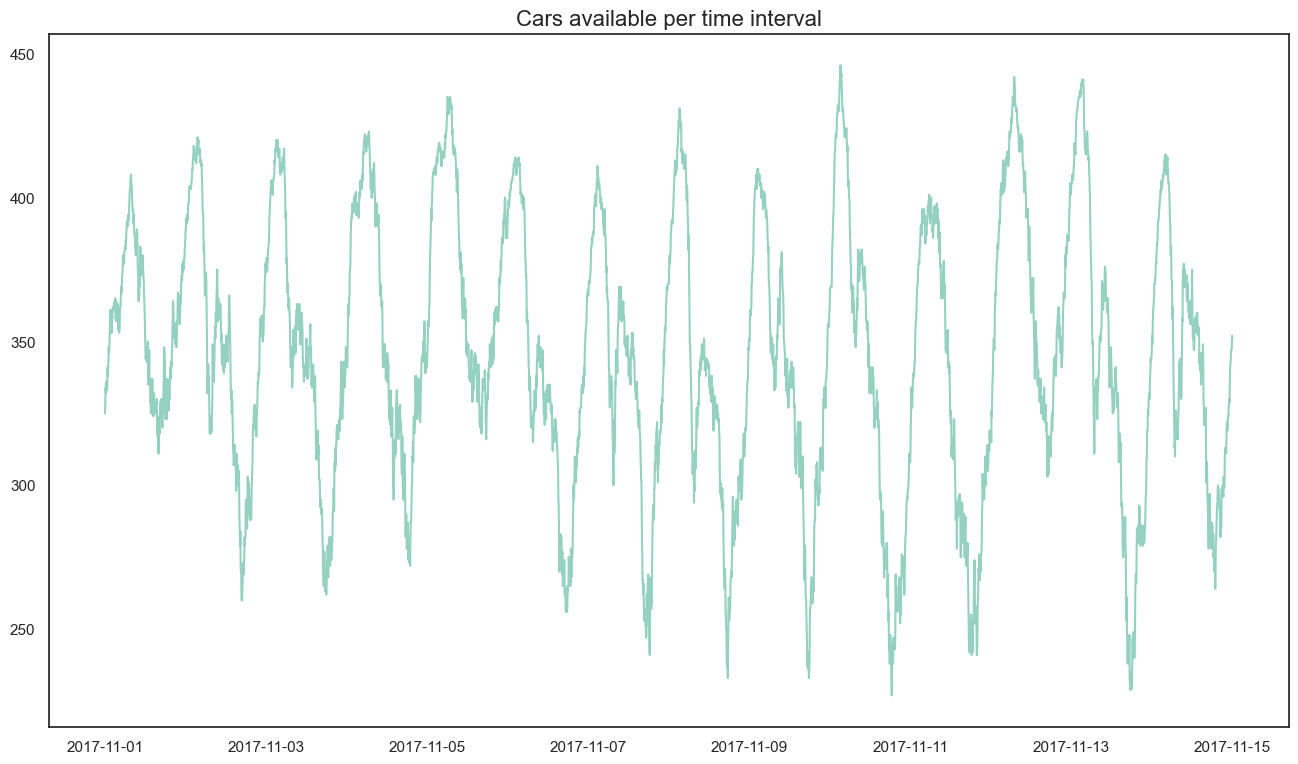

In [64]:
# Availability over time (5 min intervals)
STR_Nov_Date_avail = STR_Nov.groupby("timestamp")["car ID"].nunique() # this counts unique vehicles per 5-min time interval

fig,ax = plt.subplots(figsize=(16,9)) 

ax.plot(STR_Nov_Date_avail)
ax.set_title("Cars available per time interval",fontsize=16)

plt.show()

Next we perform some aggregations. We are interested in typical availability
- by day of week
- by hour

In [65]:
# Availability by day of week (0 = Monday, 6 = Sunday)

STR_Nov_weekday_avail = STR_Nov.groupby(["Date","Weekday"])["car ID"].nunique()
STR_Nov_weekday_avail = pd.DataFrame(STR_Nov_weekday_avail)
STR_Nov_weekday_avail

,,car ID
Date,Weekday,
2017-11-01,2,460
2017-11-02,3,468
2017-11-03,4,457
2017-11-04,5,459
2017-11-05,6,463
2017-11-06,0,461
2017-11-07,1,469
2017-11-08,2,471
2017-11-09,3,471


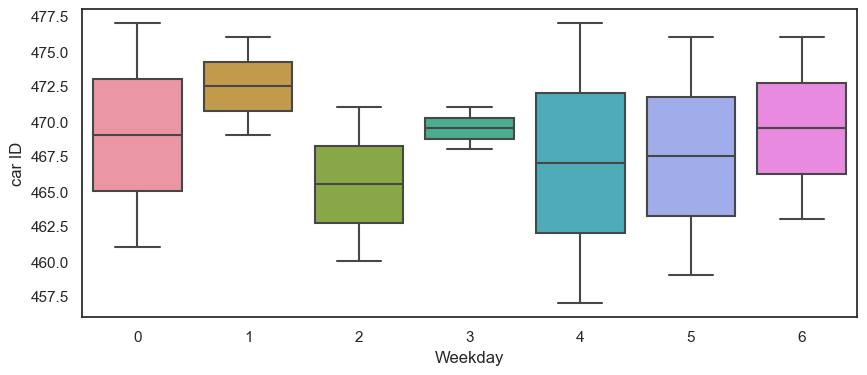

In [66]:
fig,ax = plt.subplots(figsize=(10,4)) 

sns.boxplot(x=STR_Nov_weekday_avail.index.get_level_values(1), y=STR_Nov_weekday_avail["car ID"],ax=ax)
plt.show()

In [67]:
# Availability by time of day

STR_Nov_time_avail = STR_Nov.groupby(["Date","Hour"])["car ID"].nunique()
STR_Nov_time_avail = pd.DataFrame(STR_Nov_time_avail)

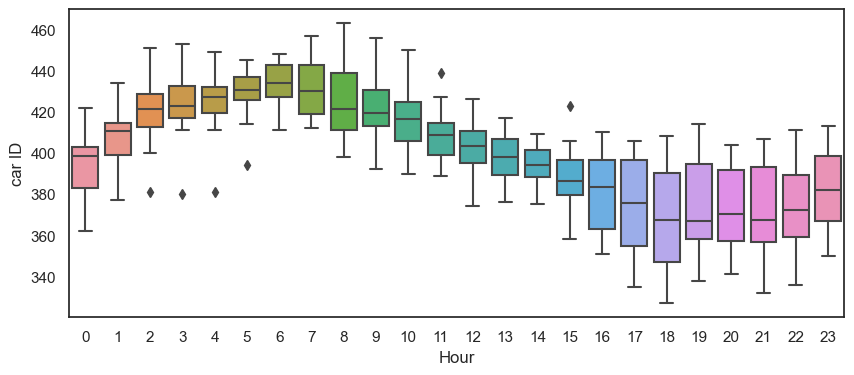

In [68]:
fig,ax = plt.subplots(figsize=(10,4)) 

sns.boxplot(x=STR_Nov_time_avail.index.get_level_values(1), y=STR_Nov_time_avail["car ID"],ax=ax)
plt.show()

### Task: What do you observe? <br>

- Describe the patterns of car availability shown in the descriptive graphs above. Which graphs are particularly instructive?
- What are your assumptions regarding the cause of the observed patterns?
- How would you expect the plot to look like if we were to plot the number of trips started?

### 2.2 Car Movement & Location Intelligence

How can we infer car movement from this data? Let's have a look at what the data provides. A lot of what follows below is a demonstation of possible geospatial analytics tasks with limited implications for VPP operations. It is, however, highly relevant from a fleet operator's point of view (Where is the demand? Where should my units be at what time?)

**Technical note**: for this tutorial we use `folium` for visualization (see [here](https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-data) for a quick introduction). For more comprehensive functionality, `geopandas` offers a powerful Python GIS data handling and plotting library (see [here](http://geopandas.org)).

In [69]:
# we first zip the latitude and longitude data
STR_Nov["Coordinates"] = list(zip(STR_Nov["lat"].round(4),STR_Nov["long"].round(4)))

STR_Nov.head()

,timestamp,car ID,long,lat,address,tank/charge level,charging,Date,Weekday,Hour,Coordinates
1355588,2017-11-01 00:00:01,WME4513901K820402,9.16004,48.78306,"KornbergstraÃe 32, 70176 Stuttgart",81,0,2017-11-01,2,0,"(48.7831, 9.16)"
767009,2017-11-01 00:00:01,WME4513901K682887,9.15871,48.81197,"Wilhelm-Geiger-Platz 10, 70469 Stuttgart",95,1,2017-11-01,2,0,"(48.812, 9.1587)"
504851,2017-11-01 00:00:01,WME4513901K664097,9.01996,48.70894,"Hugo-Distler-StraÃe 6, 71065 Sindelfingen",84,0,2017-11-01,2,0,"(48.7089, 9.02)"
540369,2017-11-01 00:00:01,WME4513901K666870,9.29360,48.75934,"Sulzgrieser StraÃe 105, 73733 Esslingen",100,1,2017-11-01,2,0,"(48.7593, 9.2936)"
1084629,2017-11-01 00:00:01,WME4513901K728465,9.15659,48.84287,"Marco-Polo-Weg 8, 70439 Stuttgart",100,0,2017-11-01,2,0,"(48.8429, 9.1566)"


Let us check where cars are typically located by plotting a heat map of locations for a given hour of the day.

In [74]:
# For performance reasons we select a single car only - pick randomly from the list
car_list = STR_Nov["car ID"].unique()
selected_car_ID = random.choice(car_list)
print(selected_car_ID)

WME4513901K667619


In [76]:
# define new map
STR_heat_map = folium.Map(location=(48.76507, 9.25371),tiles='OpenStreetMap',zoom_start=12, control_scale=True, max_zoom=20)

# add heat map
STR_heat_map.add_child(plugins.HeatMap(STR_Nov[STR_Nov["car ID"]==selected_car_ID]["Coordinates"], radius=20))

STR_heat_map

We now wish to identify the movement of the selected car. To do this, we draw the location points and trajectories.

In [77]:
# define empty map
STR_map_points = folium.Map(location=(48.76507, 9.25371),  tiles='Stamen Toner', 
                       zoom_start=10, control_scale=True, max_zoom=20)


# draw positions for selcted car
STR_Nov_car_select = STR_Nov[STR_Nov["car ID"]==selected_car_ID]

positions = list(STR_Nov_car_select["Coordinates"].unique())
for position in positions:
    folium.CircleMarker(radius=10, location=position, popup='The Waterfront', 
                                 color='crimson', fill_color='crimson').add_to(STR_map_points)
    
STR_map_points

We also add the trajectories to get an understanding of the distance traveled. Do you see any problem with such an approach?

In [78]:
STR_map_trajectory = folium.Map(location=(48.76507, 9.25371),  tiles='Stamen Toner', 
                       zoom_start=11, control_scale=True, max_zoom=20)

# draw trajectory for a selected car
folium.PolyLine(STR_Nov_car_select["Coordinates"],color="blue", weight=5, opacity=0.8, ).add_to(STR_map_trajectory)
STR_map_trajectory

### Task

- Combine the three maps into one by defining a new map and adding all three layers to that map. How does it look?

In [79]:
# define empty map
STR_map_combined = folium.Map(location=(48.76507, 9.25371),  tiles='Stamen Toner', 
                       zoom_start=9, control_scale=True, max_zoom=20)


# add heatmap
STR_map_combined.add_child(plugins.HeatMap(STR_Nov[STR_Nov["car ID"]==selected_car_ID]["Coordinates"],
                                           radius=20))

# add positions
STR_Nov_car_select = STR_Nov[STR_Nov["car ID"]==selected_car_ID]

positions = list(STR_Nov_car_select["Coordinates"].unique())
for position in positions:
    folium.CircleMarker(radius=5, location=position, popup='The Waterfront', 
                                 color='crimson', fill_color='crimson').add_to(STR_map_combined)

# add trajectories
folium.PolyLine(STR_Nov_car_select["Coordinates"],color="blue", weight=5, opacity=0.8, ).add_to(STR_map_combined)

# plot map
STR_map_combined

**Note**: from the data we can also infer where charging points must be located. Let's have a look...

### Task

- How would you identify charging positions?

In [80]:
STR_Nov.head()

,timestamp,car ID,long,lat,address,tank/charge level,charging,Date,Weekday,Hour,Coordinates
1355588,2017-11-01 00:00:01,WME4513901K820402,9.16004,48.78306,"KornbergstraÃe 32, 70176 Stuttgart",81,0,2017-11-01,2,0,"(48.7831, 9.16)"
767009,2017-11-01 00:00:01,WME4513901K682887,9.15871,48.81197,"Wilhelm-Geiger-Platz 10, 70469 Stuttgart",95,1,2017-11-01,2,0,"(48.812, 9.1587)"
504851,2017-11-01 00:00:01,WME4513901K664097,9.01996,48.70894,"Hugo-Distler-StraÃe 6, 71065 Sindelfingen",84,0,2017-11-01,2,0,"(48.7089, 9.02)"
540369,2017-11-01 00:00:01,WME4513901K666870,9.29360,48.75934,"Sulzgrieser StraÃe 105, 73733 Esslingen",100,1,2017-11-01,2,0,"(48.7593, 9.2936)"
1084629,2017-11-01 00:00:01,WME4513901K728465,9.15659,48.84287,"Marco-Polo-Weg 8, 70439 Stuttgart",100,0,2017-11-01,2,0,"(48.8429, 9.1566)"


In [81]:
# How many charging locations are there?
len(list(STR_Nov[STR_Nov["charging"]==1]["Coordinates"].unique()))

355

In [82]:
# YOUR CODE BELOW

# define dataset for plotting, i.e. charging_pos
charging_pos=list(STR_Nov[STR_Nov["charging"]==1]["Coordinates"].unique())

# define empty map
STR_map_charging = folium.Map(location=(48.76507, 9.25371),  tiles='Stamen Toner', 
                       zoom_start=9, control_scale=True, max_zoom=20)


# draw positions of charging positions
for charge_point in charging_pos:
    folium.CircleMarker(radius=3, location=charge_point, popup='The Waterfront', 
                                 color='green', fill_color='green').add_to(STR_map_charging)
    
STR_map_charging

### Task & Discussion: Limitations and how to deal with them?

- Play around with the map above and try for different vehicles by repeatedly executing the code - What do you observe?
- What are the key limitations of this data granularity?
- What are approaches to infering distance traveled?
- What are approaches to infering the exact route traveled?

### 2.3 Capacity Availability

We now wish to understand how much capacity we have available at any given point in time and can, therefore, use to trade in the ancillary market. For this we first need to define how many cars are charging at a particular instance. Also, remember the following technical information regarding the fleet:

- Battery capacity: 17.6 kWh
- Charging rate: 6 kW
- Optional fast charging: 22 kW

#### 2.3.1 Capacity for trading in the ancillary services market

In [83]:
Battery_energy_capa = 17.6 #kWh
Charging_rate = 6 #kW
Charging_rate_fast = 22 #kW
Max_EV_range = 200 #km

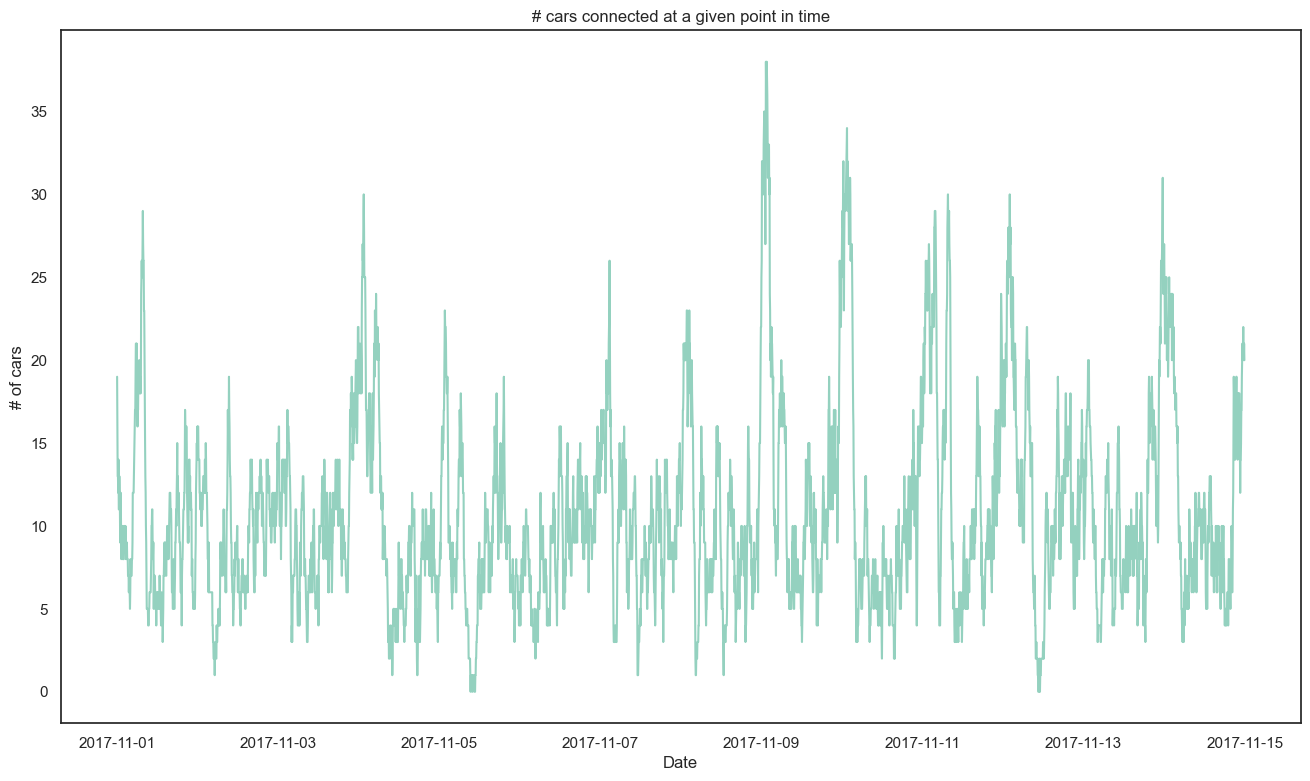

In [84]:
# Cars connected at a given point in time (we can simply sum the charging dummies)
STR_Nov_charging = STR_Nov.groupby("timestamp")["charging"].sum()

fig,ax = plt.subplots(figsize=(16,9)) 

ax.plot(STR_Nov_charging)

ax.set_title("# cars connected at a given point in time")
ax.set_ylabel("# of cars")
ax.set_xlabel("Date")

plt.show()

In [85]:
# Let us look at trends over the day - How many cars get connected per hour per time of day?
STR_Nov_charging_tod = pd.DataFrame(STR_Nov[STR_Nov["charging"]==1]).groupby(["Date","Hour"])["car ID"].nunique()
STR_Nov_charging_tod = pd.DataFrame(STR_Nov_charging_tod)

STR_Nov_charging_tod.head(10)

car ID
Date       Hour        
2017-11-01 0         27
           1         18
           2         16
           3         13
           4         19
           5         30
           6         35
           7         37
           8         26
           9         11

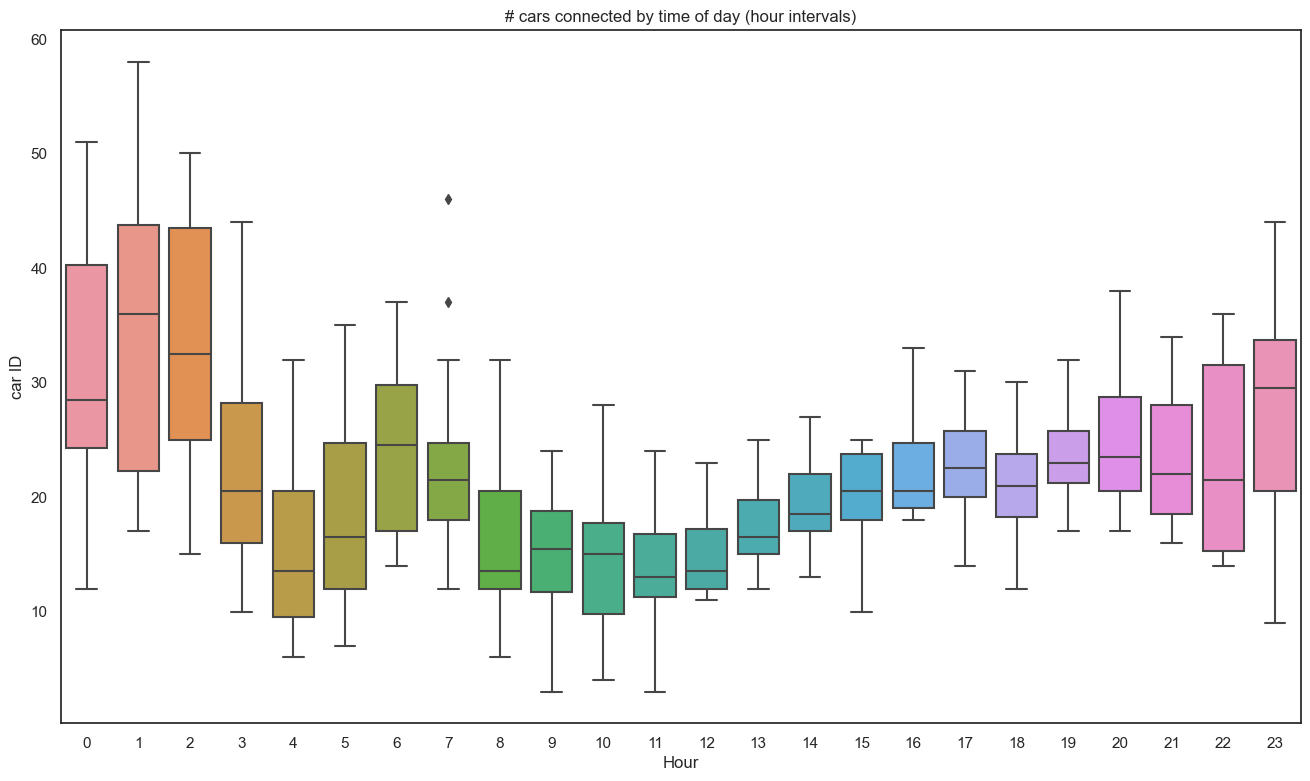

In [86]:
fig,ax = plt.subplots(figsize=(16,9)) 

sns.boxplot(x=STR_Nov_charging_tod.index.get_level_values(1), y=STR_Nov_charging_tod["car ID"],ax=ax)
ax.set_title("# cars connected by time of day (hour intervals)")
plt.show()

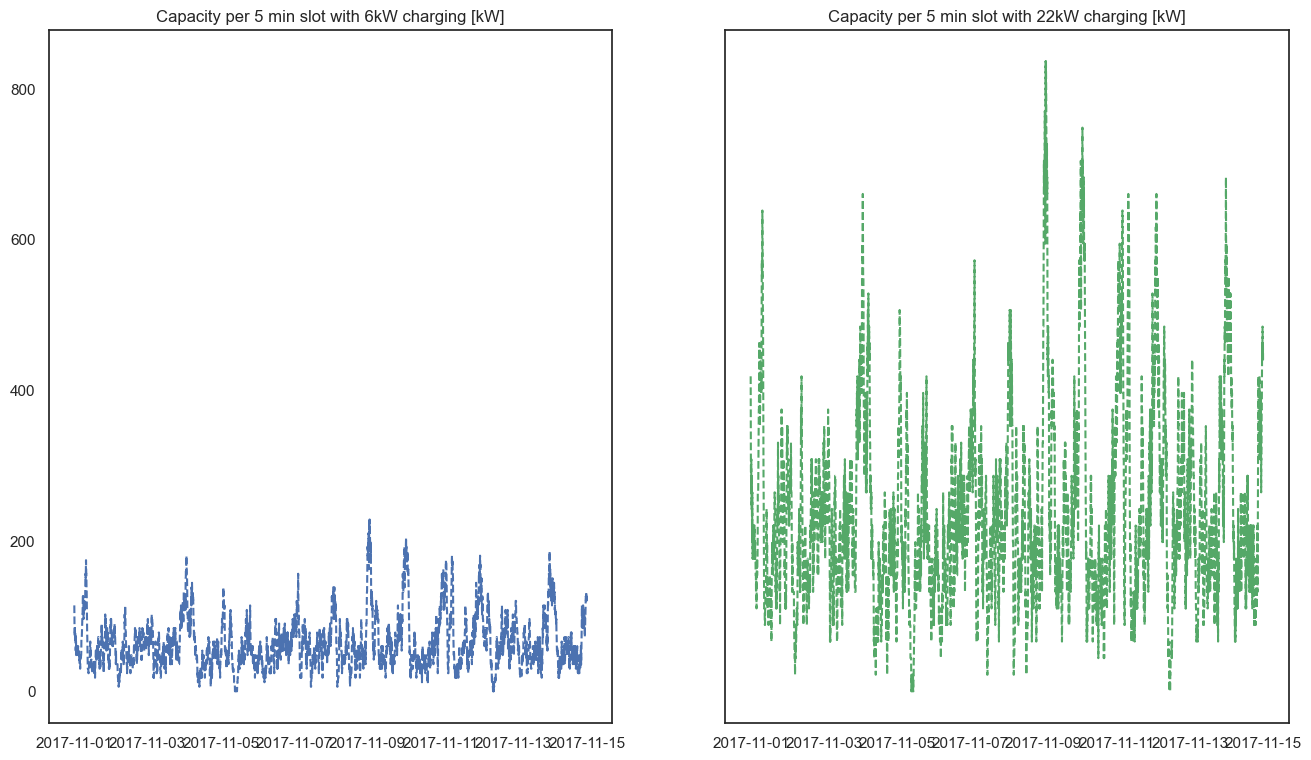

In [87]:
# after knowing the number of cars (= number of batteries) connected, let's transform this into available capacity
fig, ax = plt.subplots(figsize=(16,9), ncols=2, nrows=1, sharex=True, sharey=True)

STR_Nov_capa_normal = STR_Nov.groupby("timestamp")["charging"].sum()*Charging_rate
STR_Nov_capa_fast = STR_Nov.groupby("timestamp")["charging"].sum()*Charging_rate_fast

# Normal speed______
ax[0].set_title("Capacity per 5 min slot with 6kW charging [kW]")
ax[0].plot(STR_Nov_capa_normal, "--b")

# fast speed_______
ax[1].set_title("Capacity per 5 min slot with 22kW charging [kW]")
ax[1].plot(STR_Nov_capa_fast, "--g")

plt.show()

### Task:

- What patterns do you see? Why? Do you see scope for building a strong predictive model?
- How do you evaluate the case of using the VPP in the ancillary services markets (secondary reserve) (compare fast charging and normal charging case)? Given current market designs, can an EV VPP be successful?
- Is there scope for raising capacity at a given point in time? What are innovative apporaches towards raising available capacity at any given point in time? (compare against # of idle cars, charging station positions etc.)
- Recall the mechanism of the secondary reserve market: participants use bids for a capacity price for every 15min. Do you see any issues/constraints in using electric vehicle batteries as secondary reserve? How can the fleet operator ensure that the VPP can deliver the required capacity over the full pledged period?

#### 2.3.2 What is the battery constraint for balancing capacity provision?

In the ancillary services market you pledge capacity (in kW) for which you get reimbursed. If you get called (either for upwards or downwards regulation) you need to feed in or consume at this rate (or below). Therefore, as a plant operator, you need to demonstrate that you will be able to sustain the pledged load for the full 15min time interval.

To verify, we explore the state of charge across time for the cars that are charging as this will give us an indication for the energy that is available for upwards and downwards regulation (i.e. the time frame for which the VPP can be called) - an important constraint!

In [88]:
# connected battery capacity (in kWh)

# What do we have available for downwards regulation (i.e. how much energy can be absorbed?)
STR_Nov["Connected free Battery Capacity [kWh]"] = ((100-STR_Nov["tank/charge level"])/100)*Battery_energy_capa*STR_Nov["charging"]

# What do we have available for upwards regulation (i.e. how much energy can be fed back into the grid?)
STR_Nov["Connected SOC [kWh]"] = ((STR_Nov["tank/charge level"])/100)*Battery_energy_capa*STR_Nov["charging"]

STR_Nov.head()

,timestamp,car ID,long,lat,address,tank/charge level,charging,Date,Weekday,Hour,Coordinates,Connected free Battery Capacity [kWh],Connected SOC [kWh]
1355588,2017-11-01 00:00:01,WME4513901K820402,9.16004,48.78306,"KornbergstraÃe 32, 70176 Stuttgart",81,0,2017-11-01,2,0,"(48.7831, 9.16)",0.00,0.00
767009,2017-11-01 00:00:01,WME4513901K682887,9.15871,48.81197,"Wilhelm-Geiger-Platz 10, 70469 Stuttgart",95,1,2017-11-01,2,0,"(48.812, 9.1587)",0.88,16.72
504851,2017-11-01 00:00:01,WME4513901K664097,9.01996,48.70894,"Hugo-Distler-StraÃe 6, 71065 Sindelfingen",84,0,2017-11-01,2,0,"(48.7089, 9.02)",0.00,0.00
540369,2017-11-01 00:00:01,WME4513901K666870,9.29360,48.75934,"Sulzgrieser StraÃe 105, 73733 Esslingen",100,1,2017-11-01,2,0,"(48.7593, 9.2936)",0.00,17.60
1084629,2017-11-01 00:00:01,WME4513901K728465,9.15659,48.84287,"Marco-Polo-Weg 8, 70439 Stuttgart",100,0,2017-11-01,2,0,"(48.8429, 9.1566)",0.00,0.00


In [89]:
Connected_downwards_energy = STR_Nov[STR_Nov["charging"]==1].groupby("timestamp")["Connected free Battery Capacity [kWh]"].sum()
Connected_upwards_energy = STR_Nov[STR_Nov["charging"]==1].groupby("timestamp")["Connected SOC [kWh]"].sum()

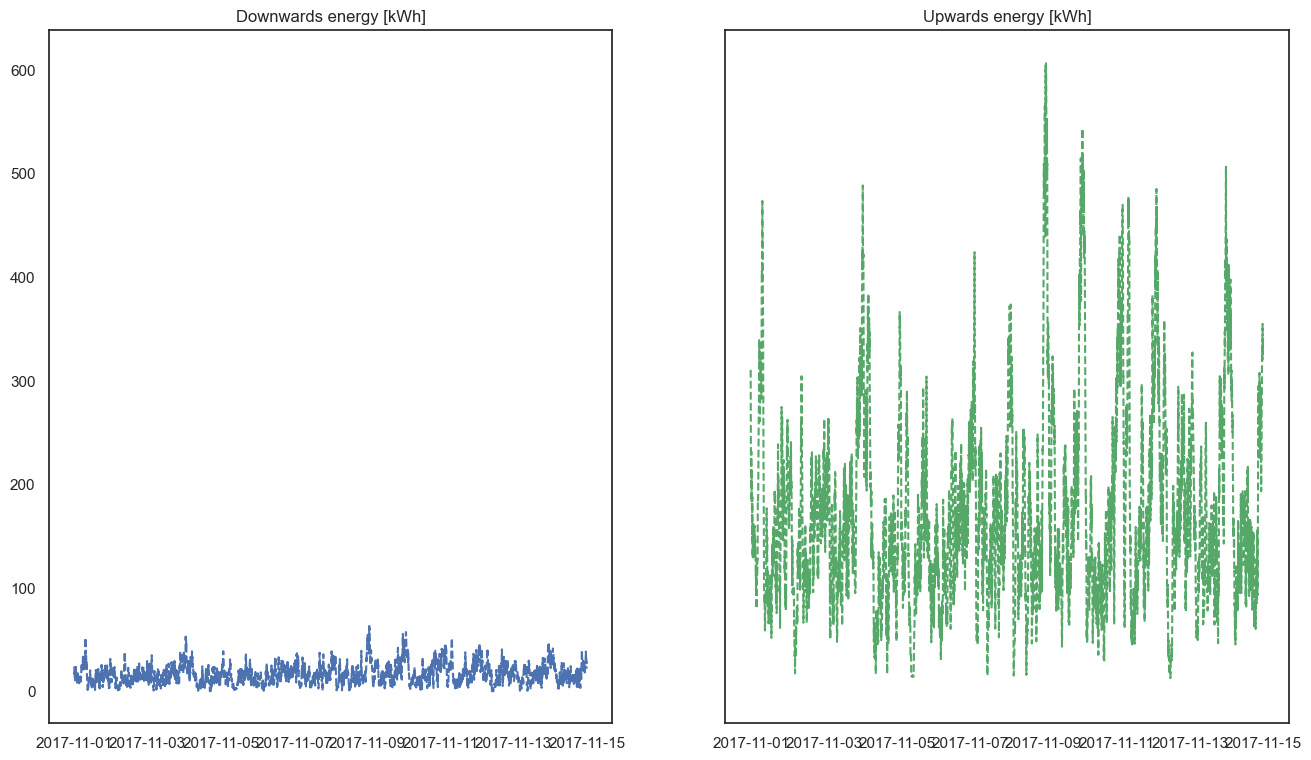

In [90]:
fig, ax = plt.subplots(figsize=(16,9), ncols=2, nrows=1, sharex=True, sharey=True)

# downwards capacity
ax[0].set_title("Downwards energy [kWh]")
ax[0].plot(Connected_downwards_energy, "--b")

# upwards capacity
ax[1].set_title("Upwards energy [kWh]")
ax[1].plot(Connected_upwards_energy, "--g")

plt.show()

### Task:

- How do you determine whether enough energy/storage capacity is available?
- From inspecting the graph above and comparing with the available capacity from above, is there a relevant state of charge constraint? Is it a problem? How big of a problem is it?
- How does this constraint influence the capacity that can be pledged in the capacity markets?